In [ ]:
!pip install pycocotools


In [ ]:

!kaggle datasets download -d awsaf49/coco-2017-dataset -p /content/drive/My\ Drive/COMP9444_project/
!unzip /content/drive/MyDrive/COMP9444_project/coco-2017-dataset.zip -d /content/drive/MyDrive/COMP9444_project/data


coco-2017-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/drive/MyDrive/COMP9444_project/coco-2017-dataset.zip
replace /content/drive/MyDrive/COMP9444_project/data/coco2017/annotations/captions_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/COMP9444_project/data/coco2017/annotations/captions_train2017.json  
  inflating: /content/drive/MyDrive/COMP9444_project/data/coco2017/annotations/captions_val2017.json  
  inflating: /content/drive/MyDrive/COMP9444_project/data/coco2017/annotations/instances_train2017.json  

In [4]:
BASE_PATH= '/content/drive/MyDrive/COMP9444_project/data/coco2017'

!pip install -q kaggle
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/COMP9444_project/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [9]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches


设置路径

In [5]:
from typing import Annotated
from pycocotools.coco import COCO

train_img_file=os.path.join(BASE_PATH,'train2017')
test_img_file=os.path.join(BASE_PATH,'test2017')
val_img_file=os.path.join(BASE_PATH,'val2017')

anno_file=os.path.join(BASE_PATH,'annotations')
train_file=os.path.join(anno_file,'captions_train2017.json')
val_file=os.path.join(anno_file,'captions_val2017.json')

In [6]:
coco_train=COCO(train_file)
coco_val=COCO(val_file)

loading annotations into memory...
Done (t=5.78s)
creating index...
index created!
loading annotations into memory...
Done (t=1.34s)
creating index...
index created!


加载图片id和信息

In [39]:
train_img_id=coco_train.getImgIds()
train_img_info=coco_train.loadImgs(train_img_id)
val_img_id=coco_val.getImgIds()
val_img_info=coco_val.loadImgs(val_img_id)
print(train_img_id[0])
print(train_img_info[0])
print(val_img_id[0])
print(val_img_info[0])

391895
{'license': 3, 'file_name': '000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}
397133
{'license': 4, 'file_name': '000000397133.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 17:02:52', 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'id': 397133}


图片地址和注释

In [42]:
def load_data(val=False,part=0):
  data_list=[]
  if val:
    ids=val_img_id
    data=coco_val
    file=val_img_file

  else:
    ids=train_img_id
    data=coco_train
    file=train_img_file

  if part>0:
    num=len(ids) // part
    ids=random.sample(ids,num)
  print(ids[0])
  for id in ids:

    annid=data.getAnnIds(id)
    anns=data.loadAnns(annid)
    caption=[ann['caption'] for ann in anns]
    img_path=os.path.join(file,"{:012d}.jpg".format(id))
    data_list.append([img_path,caption])



  return data_list

In [47]:
data_list=load_data(True,10)
data_list[0]

501005


['/content/drive/MyDrive/COMP9444_project/data/coco2017/val2017/000000501005.jpg',
 ['derek jeter swings his bat at a baseball ',
  'A hitter that just swung his bat in a baseball game.',
  'baseball players with a bat and glove at the pitch',
  'A guy is playing baseball while wearing a white uniform.',
  'A man with a baseball bat that is in the dirt.']]

id打印注释和图片


In [ ]:
def show_img(id,val=False):
  if val:
    data=coco_val
    file=val_img_file
  else:
    data=coco_train
    file=train_img_file

  annid=data.getAnnIds(id)
  anns=data.loadAnns(annid)
  data.showAnns(anns)
  img_path=os.path.join(file,"{:012d}.jpg".format(id))
  pic=cv2.imread(img_path)
  plt.imshow(pic)
  plt.axis('off')
  plt.show()

A man with a red helmet on a small moped on a dirt road. 
Man riding a motor bike on a dirt road on the countryside.
A man riding on the back of a motorcycle.
A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. 
A man in a red shirt and a red hat is on a motorcycle on a hill side.


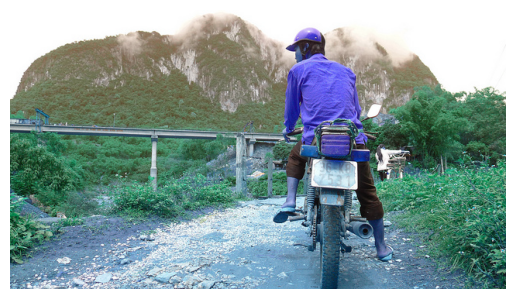

In [ ]:
show_img(train_img_id[0])